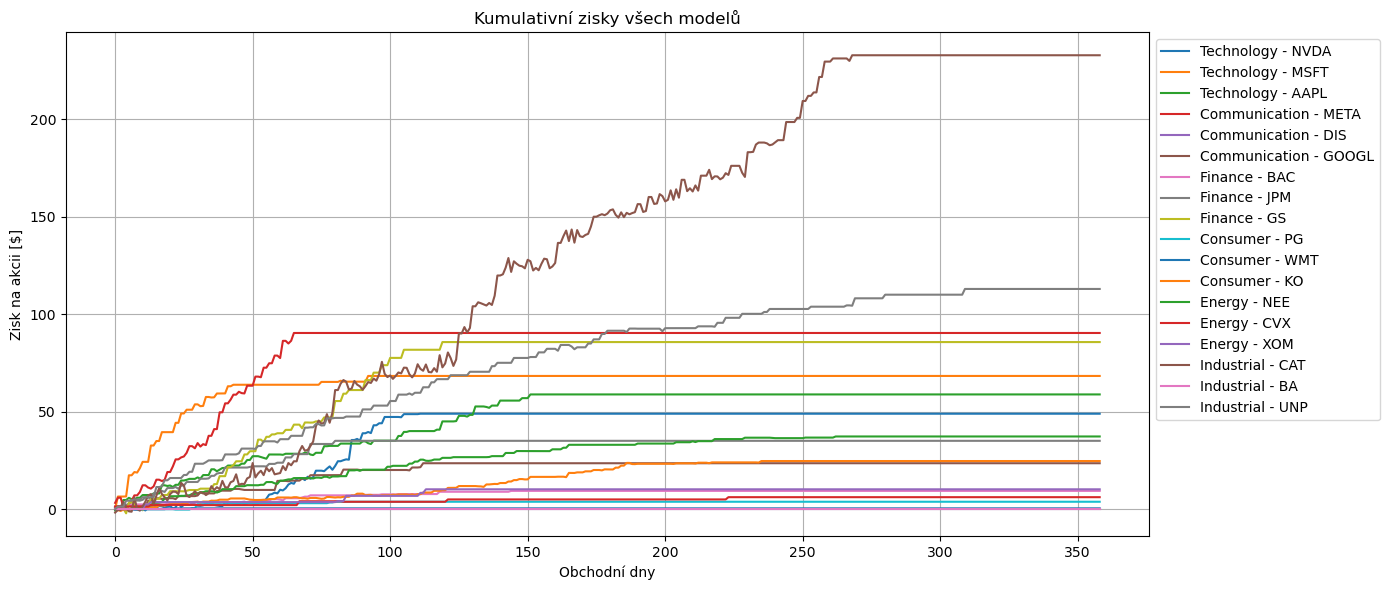


🏅 Top 5 nejziskovějších firem:
CAT (Industrial): 232.70 USD
UNP (Industrial): 112.89 USD
META (Communication): 90.32 USD
GS (Finance): 85.67 USD
MSFT (Technology): 68.30 USD


In [1]:
# 📒 Notebook: 03_train_all_models.ipynb
# Tento notebook natrénuje LSTM model pro každou firmu ve vstupních datech
# a porovná jejich kumulativní zisky na základě jednoduché predikční strategie.

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

# ✅ Přidání cesty ke složce scripts
sys.path.insert(0, os.path.abspath("../scripts"))

from utils import TimeSeriesDataset
from lstm_model import get_model
from prepare_data import load_datasets

# ⚙️ Parametry
DEVICE = "cpu"
EPOCHS = 50
LR = 0.01
BATCH_SIZE = 32

# 🔁 Načteme všechny datasety
datasets = load_datasets()
results = []

for data in datasets:
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_val = data["x_val"]
    y_val = data["y_val"]
    normalizer = data["normalizer"]

    train_ds = TimeSeriesDataset(x_train, y_train)
    val_ds = TimeSeriesDataset(x_val, y_val)

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

    model = get_model().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # 📈 Predikce
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in val_dl:
            xb = xb.to(DEVICE)
            out = model(xb).cpu().numpy()
            preds.extend(out)

    pred_prices = normalizer.inverse_transform(np.array(preds))
    true_prices = normalizer.inverse_transform(y_val)

    # 💰 Strategie
    profits = []
    for today, pred, tomorrow in zip(true_prices[:-1], pred_prices[:-1], true_prices[1:]):
        if pred > today:
            profits.append(tomorrow - today)
        else:
            profits.append(0)
    cumulative = np.cumsum(profits)

    results.append({
        "sector": data["sector"],
        "ticker": data["ticker"],
        "total_profit": cumulative[-1],
        "cumulative_profit": cumulative
    })

# 📊 Vykreslení všech výsledků
plt.figure(figsize=(14, 6))
for r in results:
    plt.plot(r["cumulative_profit"], label=f"{r['sector']} - {r['ticker']}")

plt.title("Kumulativní zisky všech modelů")
plt.xlabel("Obchodní dny")
plt.ylabel("Zisk na akcii [$]")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🏆 Nejziskovější firmy
sorted_results = sorted(results, key=lambda x: x["total_profit"], reverse=True)[:5]
print("\n🏅 Top 5 nejziskovějších firem:")
for r in sorted_results:
    print(f"{r['ticker']} ({r['sector']}): {r['total_profit']:.2f} USD")
